# GenAI with Python: Agents from scratch

###### [Article: TowardsDataScience](https://towardsdatascience.com/genai-with-python-build-agents-from-scratch-complete-tutorial-4fc1e084e2ec)

### 0 - Setup

In [1]:
#pip install langchain --> 0.2.14
#pip install langgraph --> 0.2.19
#pip install ollama --> 0.3.1
#pip install duckduckgo-search --> 6.2.12
#pip install wikipedia --> 1.4.0

In [82]:
import ollama

llm = "gemma3:4b"
q = '''Who is DP Desai ?'''

res = ollama.chat(model=llm, 
                  messages=[{"role":"system", "content":""},
                            {"role":"user", "content":q}])
res

ChatResponse(model='gemma3:4b', created_at='2025-03-15T13:45:32.650581Z', done=True, done_reason='stop', total_duration=71348825800, load_duration=69310800, prompt_eval_count=19, prompt_eval_duration=970000000, eval_count=635, eval_duration=70308000000, message=Message(role='assistant', content='DP Desai is a fascinating and somewhat enigmatic figure in the world of Indian cricket. Here\'s a breakdown of who he is:\n\n**Key Facts:**\n\n* **Former Indian Cricketer:** DP Desai was a right-handed middle-order batsman and occasional bowler who played for India from 1961 to 1966.\n* **The "Silent" Batsman:** He\'s most famously known for being one of the *quietest* batsmen in cricket history. He rarely spoke to anyone during matches – not the umpire, the captain, or his teammates. He was known for simply going out to bat, scoring runs, and returning to the pavilion without a word.\n* **Legendary Silence:** This silence was so extreme that it became a legend. It was said he didn\'t even ackn

### 1 - Tools

In [83]:
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun

@tool("tool_browser")
def tool_browser(q:str) -> str:
    """Search on DuckDuckGo browser by passing the input `q`"""
    return DuckDuckGoSearchRun().run(q)

# test
print( tool_browser(q) )

Kush Desai, a Dartmouth College graduate, holds a Bachelor of Arts degree from the Ivy League institution in Hanover, New Hampshire, where he studied from 2013 to 2017. During his time at Dartmouth, Desai earned the prestigious James O. Freedman Presidential Research Scholarship, a programme that allows students to gain research experience by ... US President Donald Trump has appointed Kush Desai, an Indian-American former journalist, as his deputy press secretary. Desai previously held key roles, including Deputy Communications Director for the 2024 Republican National Convention and Communications Director for the Republican Party of Iowa. NRI PULSE STAFF REPORT Washington, D.C., January 1, 2025 - President Donald Trump has appointed Indian-American Kush Desai as Deputy Press Secretary, making him one of the key figures in the administration's communications team. Desai will work under Deputy White House Chief of Staff and Cabinet Secretary Taylor Budowich in the White House Office o

In [84]:
@tool("final_answer")
def final_answer(text:str) -> str:
    """Returns a natural language response to the user by passing the input `text`. 
    You should provide as much context as possible and specify the source of the information.
    """
    return text

# test
print( final_answer("yo") )

yo


In [85]:
dic_tools = {"tool_browser":tool_browser, 
             "final_answer":final_answer}

### 2 - Decision Making

In [86]:
prompt = """
You know everything, you must answer every question from the user, you can use the list of tools provided to you.
Your goal is to provide the user with the best possible answer, including key information about the sources and tools used.

Note, when using a tool, you provide the tool name and the arguments to use in JSON format. 
For each call, you MUST ONLY use one tool AND the response format must ALWAYS be in the pattern:
```json
{"name":"<tool_name>", "parameters": {"<tool_input_key>":<tool_input_value>}}
```
Remember, do NOT use any tool with the same query more than once.
Remember, if the user doesn't ask a specific question, you MUST use the `final_answer` tool directly.
Remember, parameters are case-sensitive, and must be written exactly as in the tool description. ie a dictionary

Every time the user asks a question, you take note in the memory.
Every time you find some information related to the user's question, you take note in the memory.

You should aim to collect information from a diverse range of sources before providing the answer to the user. 
Once you have collected plenty of information to answer the user's question use the `final_answer` tool.
"""

In [87]:
str_tools = "\n".join([str(n+1)+". `"+str(v.name)+"`: "+str(v.description) for n,v in enumerate(dic_tools.values())])

prompt_tools = f"You can use the following tools:\n{str_tools}"
print(prompt_tools)

You can use the following tools:
1. `tool_browser`: Search on DuckDuckGo browser by passing the input `q`
2. `final_answer`: Returns a natural language response to the user by passing the input `text`. 
    You should provide as much context as possible and specify the source of the information.


In [88]:
# LLM deciding what tool to use
from pprint import pprint

llm_res = ollama.chat(
    model=llm,
    messages=[{"role":"system", "content":prompt+"\n"+prompt_tools},
              {"role":"user", "content":"hello"}
             ], format="json")

pprint(llm_res)

ChatResponse(model='gemma3:4b', created_at='2025-03-15T13:47:07.3190206Z', done=True, done_reason='stop', total_duration=21458525900, load_duration=53047200, prompt_eval_count=362, prompt_eval_duration=17513000000, eval_count=37, eval_duration=3890000000, message=Message(role='assistant', content='{"name":"final_answer", "parameters": {"text":"Hello! How can I help you today? I\'m ready to answer your questions and provide information."}}\n', images=None, tool_calls=None))


In [89]:
# LLM deciding what tool to use (output format = json)
llm_res = ollama.chat(
    model=llm,
    messages=[{"role":"system", "content":prompt+"\n"+prompt_tools},
              {"role":"user", "content":q}
             ], format="json")

llm_res["message"]["content"]

'{"name":"tool_browser", "parameters": {"q": "DP Desai"}}'

In [90]:
llm_res

ChatResponse(model='gemma3:4b', created_at='2025-03-15T13:47:21.1039833Z', done=True, done_reason='stop', total_duration=2551972100, load_duration=57815800, prompt_eval_count=366, prompt_eval_duration=519000000, eval_count=18, eval_duration=1972000000, message=Message(role='assistant', content='{"name":"tool_browser", "parameters": {"q": "DP Desai"}}', images=None, tool_calls=None))

In [91]:
import json

tool_input = json.loads(llm_res["message"]["content"])["parameters"]["q"]
tool_input

'DP Desai'

In [92]:
# LLM with context
context = tool_browser(tool_input)
print("tool output:\n", context)

llm_output = ollama.chat(
    model=llm,
    messages=[{"role":"system", "content":"Give the most accurate answer using the folling information:\n"+context},
              {"role":"user", "content":q}
             ])

print("\nllm output:\n", llm_output["message"]["content"])

tool output:
 In response to the recent fire incident at a gaming zone in Rajkot, the Gujarat government on Monday issued transfer and posting orders for three IAS officers. As part of this reshuffle, Rajkot Municipal Commissioner Anand Babulal Patel has been shifted to the General Administration Department, and DP Desai has been appointed as his replacement. IPS officer of the 1999 batch Brajesh Kumar Jha took charge post-midnight after Raju Bhargava was transferred with immediate effect DP Desai, who was earlier the chief executive officer of ... The RMC commissioner, Anand Patel was transferred, with Ahmedabad Urban Development Authority CEO DP Desai appointed in his place. Home department also transferred ACP Vidhi Chaudhary and DCP ... In a significant administrative reshuffle, the Gujarat government has appointed D P Desai, a 2008 batch IAS officer and former CEO of AUDA and GUDA, as the new Municipal Commissioner of Rajkot. He will succeed Anand Babulal Patel, a 2010 batch IAS o

### 3 - Agent Structure

##### Data Structure

In [93]:
from pydantic import BaseModel #this is the standard class

# Taking for example the last LLM response, I want this structure:
# {tool_name: 'tool_browser', 
#  tool_input: {'q':'September 9 2024 deaths'}, 
#  tool_output: str( tool_browser({'q':'September 9 2024 deaths'})) }

class AgentRes(BaseModel):
    tool_name: str  #<--must be a string = 'tool_browser'
    tool_input: dict #<--must be a dictionary = {'q':'September 9 2024 deaths'}
    tool_output: str | None = None #can be a string or None, default = None
    
    @classmethod
    def from_llm(cls, res:dict): #<--return the class itself
        try:
            out = json.loads(res["message"]["content"])
            return cls(tool_name=out["name"], tool_input=out["parameters"])
        except Exception as e:
            print(f"Error from Ollama:\n{res}\n")
            raise e

# test
agent_res = AgentRes.from_llm(llm_res)
print("from\n", llm_res["message"]["content"], "\nto")
agent_res

from
 {"name":"tool_browser", "parameters": {"q": "DP Desai"}} 
to


AgentRes(tool_name='tool_browser', tool_input={'q': 'DP Desai'}, tool_output=None)

In [94]:
# test the tool output
AgentRes(tool_name="tool_browser", 
         tool_input={'q':'September 9 2024 deaths'}, 
         tool_output=str( tool_browser({'q':'September 9 2024 deaths'})) )

AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output='Famous deaths in September 2024. Learn about 55 historical figures, notable people and celebrities who died in Sep 2024 like Pete Rose, James Earl Jones and Kris Kristofferson. ... (1931-2024) Sep 9 American Tony, Emmy, Grammy, and Golden Globe winning actor (The Great White Hope; Star Wars - "voice of Darth Vader"; Field Of Dreams"), ... The following is a list of notable deaths in September 2024. Entries for each day are listed alphabetically by surname. A typical entry lists information in the following sequence: ... [9] Norman Chui, 73, Hong Kong actor (Vengeful Beauty, Heaven Sword and Dragon Sabre, Hong Kong Godfather), esophageal cancer. What happened on September 9, 2024. Browse historical events, famous birthdays and notable deaths from Sep 9, 2024 or search by date, day or keyword. Search in the United States of people who died on September 9, 2024 obituaries and condolences. Find an 

##### Memory System

In [95]:
'''
Messages in Memory will have this structure:
[{'role':'assistant', 'content':'{"name":"final_answer", "parameters":{"text":"How can I assist you today?"}}'},
 {'role':'user', 'content':None}]
'''

def save_memory(lst_res:list[AgentRes], user_q:str) -> list:
    ## create
    memory = []
    for res in [res for res in lst_res if res.tool_output is not None]:
        memory.extend([
            ### assistant message
            {"role":"assistant", "content":json.dumps({"name":res.tool_name, "parameters":res.tool_input})},
            ### user message
            {"role":"user", "content":res.tool_output}
        ])
    
    ## add a reminder of the original goal
    if memory:
        memory += [{"role":"user", "content":(f'''
                This is just a reminder that my original query was `{user_q}`.
                Only answer to the original query, and nothing else, but use the information I gave you. 
                Provide as much information as possible when you use the `final_answer` tool.
                ''')}]
    return memory

# test
save_memory(lst_res=[agent_res], user_q=q)

[]

In [96]:
chat_history = [{"role": "user", "content": "hi there, how are you?"},
                {"role": "assistant", "content": "I'm good, thanks!"},
                {"role": "user", "content": "I have a question"},
                {"role": "assistant", "content": "tell me"}]

##### Run the Agent

In [97]:
def run_agent(prompt:str, dic_tools:dict, user_q:str, chat_history:list[dict], lst_res:list[AgentRes]) -> AgentRes:
    ## start memory
    memory = save_memory(lst_res=lst_res, user_q=user_q)
    
    ## track used tools
    if memory:
        tools_used = [res.tool_name for res in lst_res]
        if len(tools_used) >= len(dic_tools.keys()):
            memory[-1]["content"] = "You must now use the `final_answer` tool."

    ## prompt tools
    str_tools = "\n".join([str(n+1)+". `"+str(v.name)+"`: "+str(v.description) for n,v in enumerate(dic_tools.values())])
    prompt_tools = f"You can use the following tools:\n{str_tools}"
        
    ## messages
    messages = [{"role":"system", "content":prompt+"\n"+prompt_tools},
                *chat_history,
                {"role":"user", "content":user_q},
                *memory]
    #pprint(messages) #<--print to see prompt + tools + chat_history
    
    ## output
    llm_res = ollama.chat(model=llm, messages=messages, format="json")
    return AgentRes.from_llm(llm_res)

# test
agent_res = run_agent(prompt=prompt, dic_tools=dic_tools, user_q=q, chat_history=chat_history, lst_res=[])
print("\nagent_res:", agent_res)


agent_res: tool_name='tool_browser' tool_input={'q': 'DP Desai'} tool_output=None


### 4 - Graph Workflow

##### State

In [98]:
import typing

class State(typing.TypedDict):
    user_q: str
    chat_history: list 
    lst_res: list[AgentRes]
    output: dict

# test
state = State({"user_q":q, "chat_history":chat_history, "lst_res":[agent_res], "output":{}})
state

{'user_q': 'Who is DP Desai ?',
 'chat_history': [{'role': 'user', 'content': 'hi there, how are you?'},
  {'role': 'assistant', 'content': "I'm good, thanks!"},
  {'role': 'user', 'content': 'I have a question'},
  {'role': 'assistant', 'content': 'tell me'}],
 'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'DP Desai'}, tool_output=None)],
 'output': {}}

##### Nodes

In [99]:
# Agent
def node_agent(state):
    print("--- node_agent ---")
    agent_res = run_agent(prompt=prompt, 
                          dic_tools={k:v for k,v in dic_tools.items() if k in ["tool_browser","final_answer"]},
                          user_q=state["user_q"], 
                          chat_history=state["chat_history"], 
                          lst_res=state["lst_res"])
    print(agent_res)
    return {"lst_res":[agent_res]} #<--must return a the list of agent_res

# test
node_agent(state)

--- node_agent ---
tool_name='tool_browser' tool_input={'q': 'DP Desai'} tool_output=None


{'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'DP Desai'}, tool_output=None)]}

In [100]:
# Tools
def node_tool(state):
    print("--- node_tool ---")
    res = state["lst_res"][-1]
    print(f"{res.tool_name}(input={res.tool_input})")
    
    agent_res = AgentRes(tool_name=res.tool_name, 
                         tool_input=res.tool_input, 
                         tool_output=str(dic_tools[res.tool_name](res.tool_input)) )
    
    return {"output":agent_res} if res.tool_name == "final_answer" else {"lst_res":[agent_res]}

# test
node_tool(state)

--- node_tool ---
tool_browser(input={'q': 'DP Desai'})


{'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'DP Desai'}, tool_output="In response to the recent fire incident at a gaming zone in Rajkot, the Gujarat government on Monday issued transfer and posting orders for three IAS officers. As part of this reshuffle, Rajkot Municipal Commissioner Anand Babulal Patel has been shifted to the General Administration Department, and DP Desai has been appointed as his replacement. In a significant administrative reshuffle, the Gujarat government has appointed D P Desai, a 2008 batch IAS officer and former CEO of AUDA and GUDA, as the new Municipal Commissioner of Rajkot. He will succeed Anand Babulal Patel, a 2010 batch IAS officer, current Municipal Commissioner of Rajkot, who has been transferred to the General ... After tragic TRP fire tragedy, DP Desai appointed as new Commissioner of Rajkot Municipal Corporation #Gujarat #breakingnews #News Stay connected with us on ... The Gujarat government has also transferred the Rajkot Mu

##### Edges

In [101]:
def conditional_edges(state):
    print("--- conditional_edges ---")
    last_res = state["lst_res"][-1]
    next_node = last_res.tool_name if isinstance(state["lst_res"], list) else "final_answer"
    print("next_node:", next_node)
    return next_node #<--must return the next node to go

# test
conditional_edges(state)

--- conditional_edges ---
next_node: tool_browser


'tool_browser'

##### Graph

In [102]:
from langgraph.graph import StateGraph, END

## start the graph
workflow = StateGraph(State)

## add Agent node
workflow.add_node(node="Agent", action=node_agent) 
workflow.set_entry_point(key="Agent")  #<--user query

## add Tools nodes
for k in dic_tools.keys():
    workflow.add_node(node=k, action=node_tool)

## conditional_edges from Agent
workflow.add_conditional_edges(source="Agent", path=conditional_edges)

## normal_edges to Agent
for k in dic_tools.keys():
    if k != "final_answer":
        workflow.add_edge(start_key=k, end_key="Agent")

## end the graph
workflow.add_edge(start_key="final_answer", end_key=END)
g = workflow.compile()

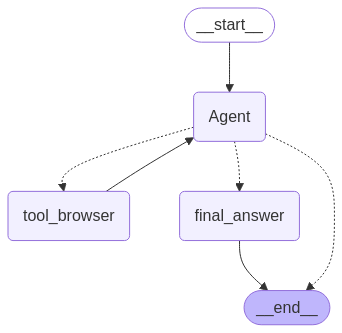

In [103]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(Image(
    g.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
))

##### Run

In [104]:
## input initial state
initial_state = {'user_q':q,
                 'chat_history':chat_history, 
                 'lst_res':[],
                 'output':{} }

In [105]:
out = g.invoke(input=initial_state)
agent_out = out['output'].tool_output

print("----")
agent_out

--- node_agent ---
tool_name='tool_browser' tool_input={'q': 'DP Desai'} tool_output=None
--- conditional_edges ---
next_node: tool_browser
--- node_tool ---
tool_browser(input={'q': 'DP Desai'})
--- node_agent ---
tool_name='final_answer' tool_input={'text': 'DP Desai has been appointed as the new Municipal Commissioner of Rajkot, succeeding Anand Babulal Patel. He is a 2008 batch IAS officer and was previously the CEO of AUDA and GUDA. According to the article, this appointment follows the recent fire incident at a gaming zone in Rajkot. The source is a news article discussing the administrative reshuffle in Gujarat.'} tool_output=None
--- conditional_edges ---
next_node: final_answer
--- node_tool ---
final_answer(input={'text': 'DP Desai has been appointed as the new Municipal Commissioner of Rajkot, succeeding Anand Babulal Patel. He is a 2008 batch IAS officer and was previously the CEO of AUDA and GUDA. According to the article, this appointment follows the recent fire incident 

'DP Desai has been appointed as the new Municipal Commissioner of Rajkot, succeeding Anand Babulal Patel. He is a 2008 batch IAS officer and was previously the CEO of AUDA and GUDA. According to the article, this appointment follows the recent fire incident at a gaming zone in Rajkot. The source is a news article discussing the administrative reshuffle in Gujarat.'

In [106]:
steps = g.stream(input=initial_state) 
for n,step in enumerate(steps):
    print("--- step", n, "---")
    print(step)

--- node_agent ---
tool_name='tool_browser' tool_input={'q': 'DP Desai'} tool_output=None
--- conditional_edges ---
next_node: tool_browser
--- step 0 ---
{'Agent': {'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'DP Desai'}, tool_output=None)]}}
--- node_tool ---
tool_browser(input={'q': 'DP Desai'})
--- step 1 ---
{'tool_browser': {'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'DP Desai'}, tool_output='In response to the recent fire incident at a gaming zone in Rajkot, the Gujarat government on Monday issued transfer and posting orders for three IAS officers. As part of this reshuffle, Rajkot Municipal Commissioner Anand Babulal Patel has been shifted to the General Administration Department, and DP Desai has been appointed as his replacement. IPS officer of the 1999 batch Brajesh Kumar Jha took charge post-midnight after Raju Bhargava was transferred with immediate effect DP Desai, who was earlier the chief executive officer of ... The RMC commissi

### 5 - Multi-Agent & Human-in-the-Loop

##### Second Agent

In [107]:
agent_out

'DP Desai has been appointed as the new Municipal Commissioner of Rajkot, succeeding Anand Babulal Patel. He is a 2008 batch IAS officer and was previously the CEO of AUDA and GUDA. According to the article, this appointment follows the recent fire incident at a gaming zone in Rajkot. The source is a news article discussing the administrative reshuffle in Gujarat.'

In [108]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

@tool("tool_wikipedia")
def tool_wikipedia(q:str) -> str:
    """Search on Wikipedia by passing the input `q`.
       The input `q` must be short keywords, not a long text"""
    return WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper()).run(q)

# test
print( tool_wikipedia(agent_out) )

No good Wikipedia Search Result was found


In [109]:
dic_tools = {"tool_browser":tool_browser,
             "final_answer":final_answer,
             "tool_wikipedia":tool_wikipedia}

In [110]:
prompt_2 = """
Your goal is to use the `tool_wikipedia` ONLY ONCE to enrich the information already available.
Note, when using a tool, you provide the tool name and the arguments to use in JSON format. 
For each call, you MUST ONLY use one tool AND the response format must ALWAYS be in the pattern:
```json
{"name":"<tool_name>", "parameters": {"<tool_input_key>":<tool_input_value>}}
```
First you must use the `tool_wikipedia`, then elaborate the information to answer the user's question with `final_answer` tool.
"""

In [111]:
def node_agent_2(state):
    print("--- node_agent 2 ---")
    agent_res = run_agent(prompt=prompt_2, 
                          dic_tools={k:v for k,v in dic_tools.items() if k in ["tool_wikipedia","final_answer"]},
                          user_q=state["output"].tool_output, #<--changed user_q to the last output
                          chat_history=state["chat_history"], 
                          lst_res=state["lst_res"])
    print(agent_res)
    return {"lst_res":[agent_res]} #<--must return a the list of agent_res

##### Human in the Loop

In [112]:
# Node
def human_node(state):
    pass

# Conditional Edges
def human_edges(state):
    print("--- human ---")
    user_feedback = input("Should I continue? [Yes/No] --> ")
    next_node = "Agent2" if user_feedback.lower()[0] == "y" else END
    print("next_node:", next_node)
    return next_node #<--must return the next node to go

# test
human_edges(state)

--- human ---
next_node: Agent2


'Agent2'

##### New Graph

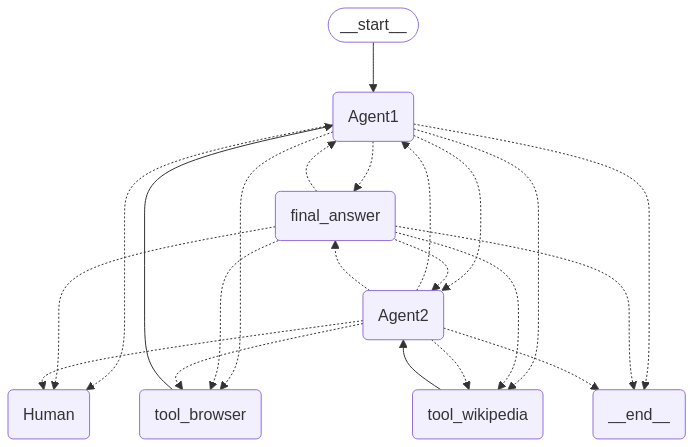

In [113]:
## start the graph
workflow = StateGraph(State)

########################## Agent 1 ##########################
## add Agent node
workflow.add_node(node="Agent1", action=node_agent) 
workflow.set_entry_point(key="Agent1") #<--user query

## add Tools nodes
workflow.add_node(node="tool_browser", action=node_tool)
workflow.add_node(node="final_answer", action=node_tool)

## normal_edges to Agent
workflow.add_edge(start_key="tool_browser", end_key="Agent1")

## conditional_edges from Agent
workflow.add_conditional_edges(source="Agent1", path=conditional_edges)

########################## Human ##########################
## add Human node
workflow.add_node(node="Human", action=human_node)

## conditional_edges from Human
workflow.add_conditional_edges(source="final_answer", path=human_edges)

########################## Agent 2 ##########################
## add Agent node
workflow.add_node(node="Agent2", action=node_agent_2) 

## add Tools nodes
workflow.add_node(node="tool_wikipedia", action=node_tool)

## normal_edges to Agent
workflow.add_edge(start_key="tool_wikipedia", end_key="Agent2")

## conditional_edges from Agent
workflow.add_conditional_edges(source="Agent2", path=conditional_edges)

########################## End ##########################
## end the graph
g2 = workflow.compile()

## plot
display(Image(
    g2.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
))

In [114]:
initial_state

{'user_q': 'Who is DP Desai ?',
 'chat_history': [{'role': 'user', 'content': 'hi there, how are you?'},
  {'role': 'assistant', 'content': "I'm good, thanks!"},
  {'role': 'user', 'content': 'I have a question'},
  {'role': 'assistant', 'content': 'tell me'}],
 'lst_res': [],
 'output': {}}

In [115]:
out_2 = g2.invoke(input=initial_state)
agent_out_2 = out_2['output'].tool_output

print("----")
agent_out_2

--- node_agent ---
tool_name='tool_browser' tool_input={'q': 'DP Desai who'} tool_output=None
--- conditional_edges ---
next_node: tool_browser
--- node_tool ---
tool_browser(input={'q': 'DP Desai who'})
--- node_agent ---
tool_name='final_answer' tool_input={'text': 'DP Desai is currently the Chief Executive Officer of the Ahmedabad Urban Development Authority (AUDA) and has also been appointed as the CEO of the Gandhinagar Urban Development Authority (GUDA) in addition to his role at AUDA. He was appointed as replacement for Rajkot Municipal Commissioner Anand Patel, as confirmed by the Gujarat government’s General Administration Department. DP Desai is a 2010-batch IAS officer. This information was sourced from a news article detailing the Gujarat government’s administrative transfers.'} tool_output=None
--- conditional_edges ---
next_node: final_answer
--- node_tool ---
final_answer(input={'text': 'DP Desai is currently the Chief Executive Officer of the Ahmedabad Urban Development

JSONDecodeError: Expecting ',' delimiter: line 1 column 1301 (char 1300)